In [2]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

import nltk
nltk.download('punkt')
import re
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

import gensim #gensim is an open source library for unsupervised topic modeling and natural language  
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# import keras
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Input,LSTM,Conv1D,MaxPool1D,Bidirectional
from tensorflow.keras.models import Model

from jupyterthemes import jtplot
jtplot.style(theme='monokai',context='notebook',ticks=True,grid=False)
# setting style to be monokai theme





[nltk_data] Downloading package punkt to /home/abdessamad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# loading the dataset
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

In [11]:
print("the size of data sample for the true "+str(df_true.shape[0])+' there are '+str(df_true.isnull().sum())+' null element')
print("the size of data sample for the true "+str(df_fake.shape[0])+'there are '+str(df_fake.isnull().sum())+'null element')


the size of data sample for the true 21417 there are title      0
text       0
subject    0
date       0
dtype: int64 null element
the size of data sample for the true 23481there are title      0
text       0
subject    0
date       0
dtype: int64null element


In [12]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [13]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


<h1>Task Perform feauture engineering</h1>

In [15]:
#add target class column to indicate wheter the news is real or fake
df_true['isFake'] = 0
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isFake  
0  December 31, 2017        0  
1  December 29, 2017        0  
2  December 31, 2017        0  
3  December 30, 2017        0  
4  December 29, 2017        0

In [16]:
df_fake['isFake']=1
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isFake  
0  December 31, 2017       1  
1  December 31, 2017       1  
2  December 30, 2017       1  
3  December 29, 2017       1  
4  December 25, 2017       1

In [17]:
#concatenate real and fake
df = pd.concat([df_true,df_fake]).reset_index(drop=True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isFake  
0      December 31, 2017        0  
1      December 29, 2017        0  
2      December 31, 2017        0  
3      December 30, 2017        0  
4      December 29, 2017        0  
...                   ...     ...  
44893    January 16, 2016       1  
44894    January 16, 2016       1  
44895    January 15, 2016       1  
44896    January 14, 2016       1  
44897    January 12, 2016       1  

[44898 rows x 5 columns]

In [18]:
df.drop(columns=['date'],inplace=True)

In [19]:
df['original'] = df['title']+' '+df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  isFake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews       0   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews       0   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews       0   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews       0   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews       0   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [20]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

<h1>Data cleaning</h1>

In [21]:
#download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abdessamad/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
#obtain additional stopwords from nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.extend(['from','subject','re','edu','use'])

In [24]:
stopwords



['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
#remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stopwords:
            result.append(token)

    return result

In [26]:
df['clean'] = df['original'].apply(preprocess)

In [27]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [28]:
df['clean'][0]

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [29]:
list_of_words = []
for i in df.clean:
    for j in i :
        list_of_words.append(j)

In [30]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [31]:
len(list_of_words)

9276947

In [32]:
#Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [33]:
#join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x:' '.join(x))


In [34]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isFake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...  

[44898 rows x 7 columns]

In [35]:
df["clean_joined"][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

<h1>visualize cleaned dataset</h1>

In [36]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isFake                                           original  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           0  U.S. military to accept transgender recruits o...   
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           0  FBI Russia probe helped by Australian diplomat...   
4           0  Trump wants Postal Service to charge 'much mor...   
...       ...                                                ...   
44893       1  McPain: John McCain Furious That Iran Treated ...   
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896       1  How to Blow $700 Million: Al Jazeera America F...   
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...  

[44898 rows x 7 columns]

<AxesSubplot:xlabel='count', ylabel='subject'>

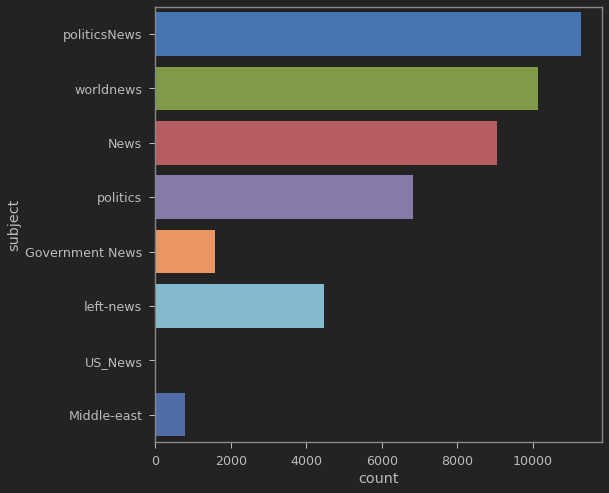

In [37]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject',data=df)

<AxesSubplot:xlabel='count', ylabel='isFake'>

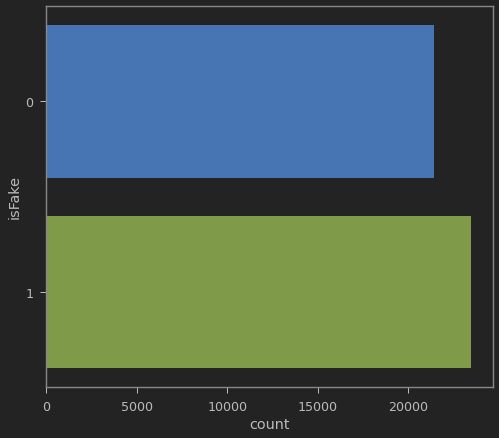

In [38]:
sns.countplot(y='isFake',data=df)

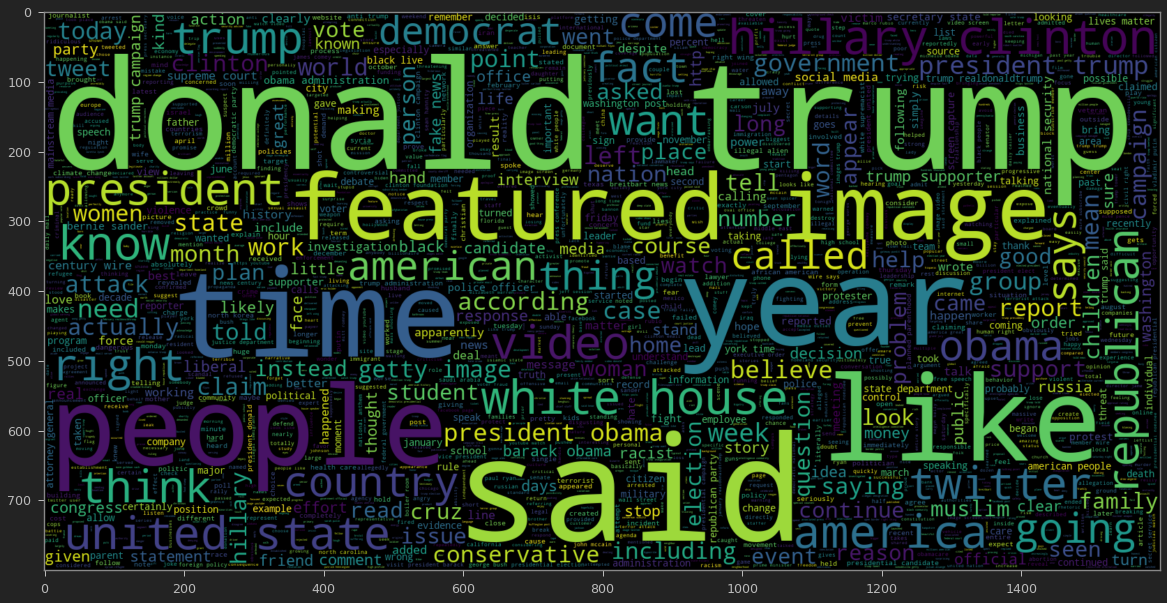

In [40]:
# plot the word cloud for text that is fake
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000,width=1600,height=800,stopwords=stopwords).generate(' '.join(df[df.isFake==1].clean_joined))
plt.imshow(wc,interpolation='bilinear')

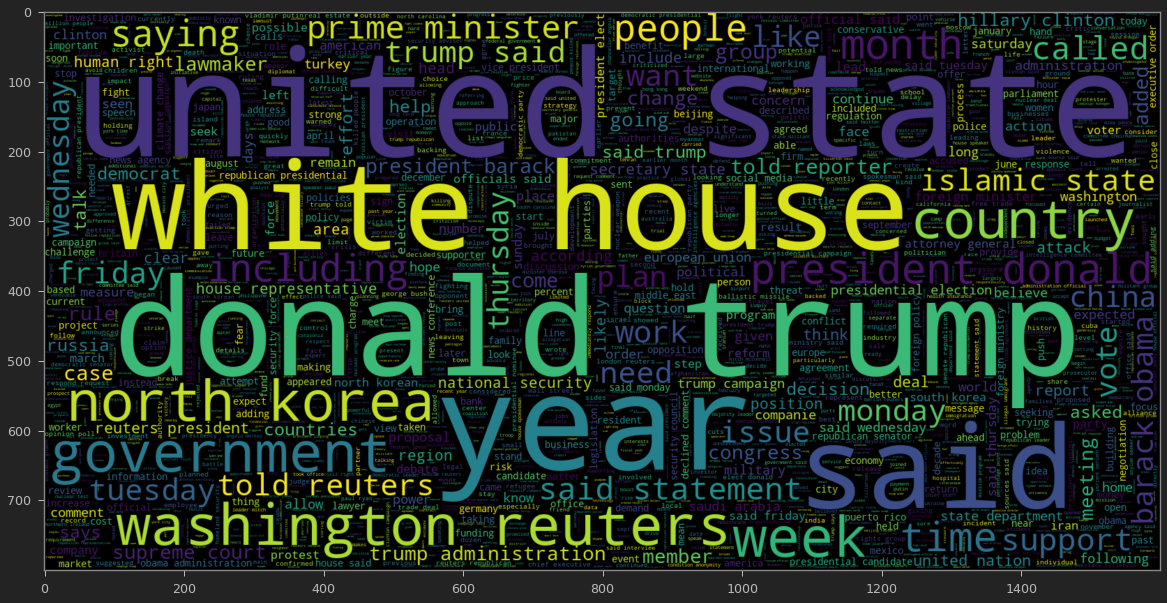

In [41]:
# plot the word cloud for text that is real
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000,width=1600,height=800,stopwords=stopwords).generate(' '.join(df[df.isFake==0].clean_joined))
plt.imshow(wc,interpolation='bilinear')

In [42]:
#length of maximum document(News) will be needed to create word embeddings
maxlen= -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print('The maximum length of words in any dowument is =',maxlen)

The maximum length of words in any dowument is = 4405


In [44]:
#visualize the distribuion of number of words in a text
import plotly.express as px
fig = px.histogram(x=[len(nltk.word_tokenize(x))for x in df.clean_joined],nbins=100)
fig.show()

<h1>preparing data by performing toenization and padding</h1>

Tokenizer
<p>tokenizer allows us to vectorize text corpus by turning each text into a sequence of integers</p>

In [46]:
# split data into test and train
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df.clean_joined,df.isFake,test_size =0.2)

In [47]:
from nltk import word_tokenize

In [48]:
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [49]:
len(train_sequences)

35918

In [50]:
train_sequences

[[446,
  295,
  720,
  358,
  20671,
  1147,
  864,
  358,
  8,
  39,
  141,
  90,
  5017,
  1225,
  134,
  1056,
  1391,
  245,
  22,
  376,
  670,
  29,
  76,
  3602,
  17906,
  156,
  581,
  1629,
  997,
  1537,
  402,
  446,
  742,
  789,
  1673,
  4776,
  23,
  5243,
  8396,
  1260,
  2391,
  83,
  3,
  173,
  6,
  358,
  451,
  10041,
  556,
  2336,
  932,
  192,
  4452,
  8,
  520,
  1711,
  2,
  682,
  149,
  2336,
  1334,
  2726,
  446,
  2337,
  344,
  589,
  2116,
  453,
  8,
  134,
  90,
  1551,
  3842,
  358,
  1601,
  2503,
  29,
  1412,
  447,
  864,
  3025,
  510,
  17907,
  3603,
  100,
  4,
  581,
  2336,
  4689,
  7795,
  201,
  90,
  192,
  520,
  1711,
  556,
  2875,
  10948,
  931,
  2076,
  597,
  913,
  472,
  358,
  520,
  1711,
  14786,
  1728,
  109,
  8,
  13,
  237,
  536,
  1403,
  5689,
  798,
  366,
  556,
  641,
  7067,
  49,
  692,
  2,
  109,
  3349,
  282,
  90,
  1551,
  2336,
  2,
  54,
  464,
  450,
  73,
  717,
  1743,
  147,
  2691,
  148,
  437

In [51]:
len(test_sequences)

8980

In [52]:
print("the encoding for document \n",df.clean_joined[0],'\n is :',train_sequences[0])

the encoding for document 
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats sa

In [54]:
# add padding can either be maxlen = 4405 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen=4405,padding ='post',truncating='post')
padded_test = pad_sequences(test_sequences,maxlen=4405,truncating = 'post')

In [55]:
for i,doc in enumerate(padded_train[:2]):
    print('the padded encoding for document',i+1,'is :',doc)

the padded encoding for document 1 is : [446 295 720 ...   0   0   0]
the padded encoding for document 2 is : [248  92 361 ...   0   0   0]


<h1>Build and train lstm network</h1>

In [56]:
#sequential Model
model=Sequential()

#embedding layer
model.add(Embedding(total_words,output_dim=128))

#Bi-directional RNN/lstm
model.add(Bidirectional(LSTM(128)))

#Dense layers
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['acc'])
model.summary()


2022-03-22 12:05:06.570852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-22 12:05:06.570877: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 12:05:06.570891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (THE-LEGEND): /proc/driver/nvidia/version does not exist
2022-03-22 12:05:06.571090: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         13914112  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [57]:
y_train = np.asarray(y_train)

In [61]:
# train the model  cpu intesive moved to google colab
model.fit(padded_train,y_train,batch_size=64,validation_split=0.1,epochs=2)

Epoch 1/2
506/506 [==============================] - 2555s 5s/step - loss: 0.0053 - acc: 0.9986 - val_loss: 0.0054 - val_acc: 0.9986
Epoch 2/2
506/506 [==============================] - 2381s 5s/step - loss: 7.5098e-04 - acc: 0.9997 - val_loss: 0.0022 - val_acc: 0.9992


<h1>Assess trained model performance </h1>

In [67]:
#make prediction
pred = model.predict(padded_test)


In [68]:
pred

array([[0.9991079 ],
       [0.9991144 ],
       [0.9991175 ],
       ...,
       [0.9991095 ],
       [0.999092  ],
       [0.99911267]], dtype=float32)

In [73]:
pred[0][0]

0.9991079

In [74]:
# if the prediction value is >0.5 it is real else fake
prediction = []
for i in range(len(pred)):
    #if pred[i][0].item>0.5:
    if pred[i][0]>0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [75]:
#getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test),prediction)
print('Model Accuracy: ',accuracy)


Model Accuracy:  0.5178173719376392


<AxesSubplot:>

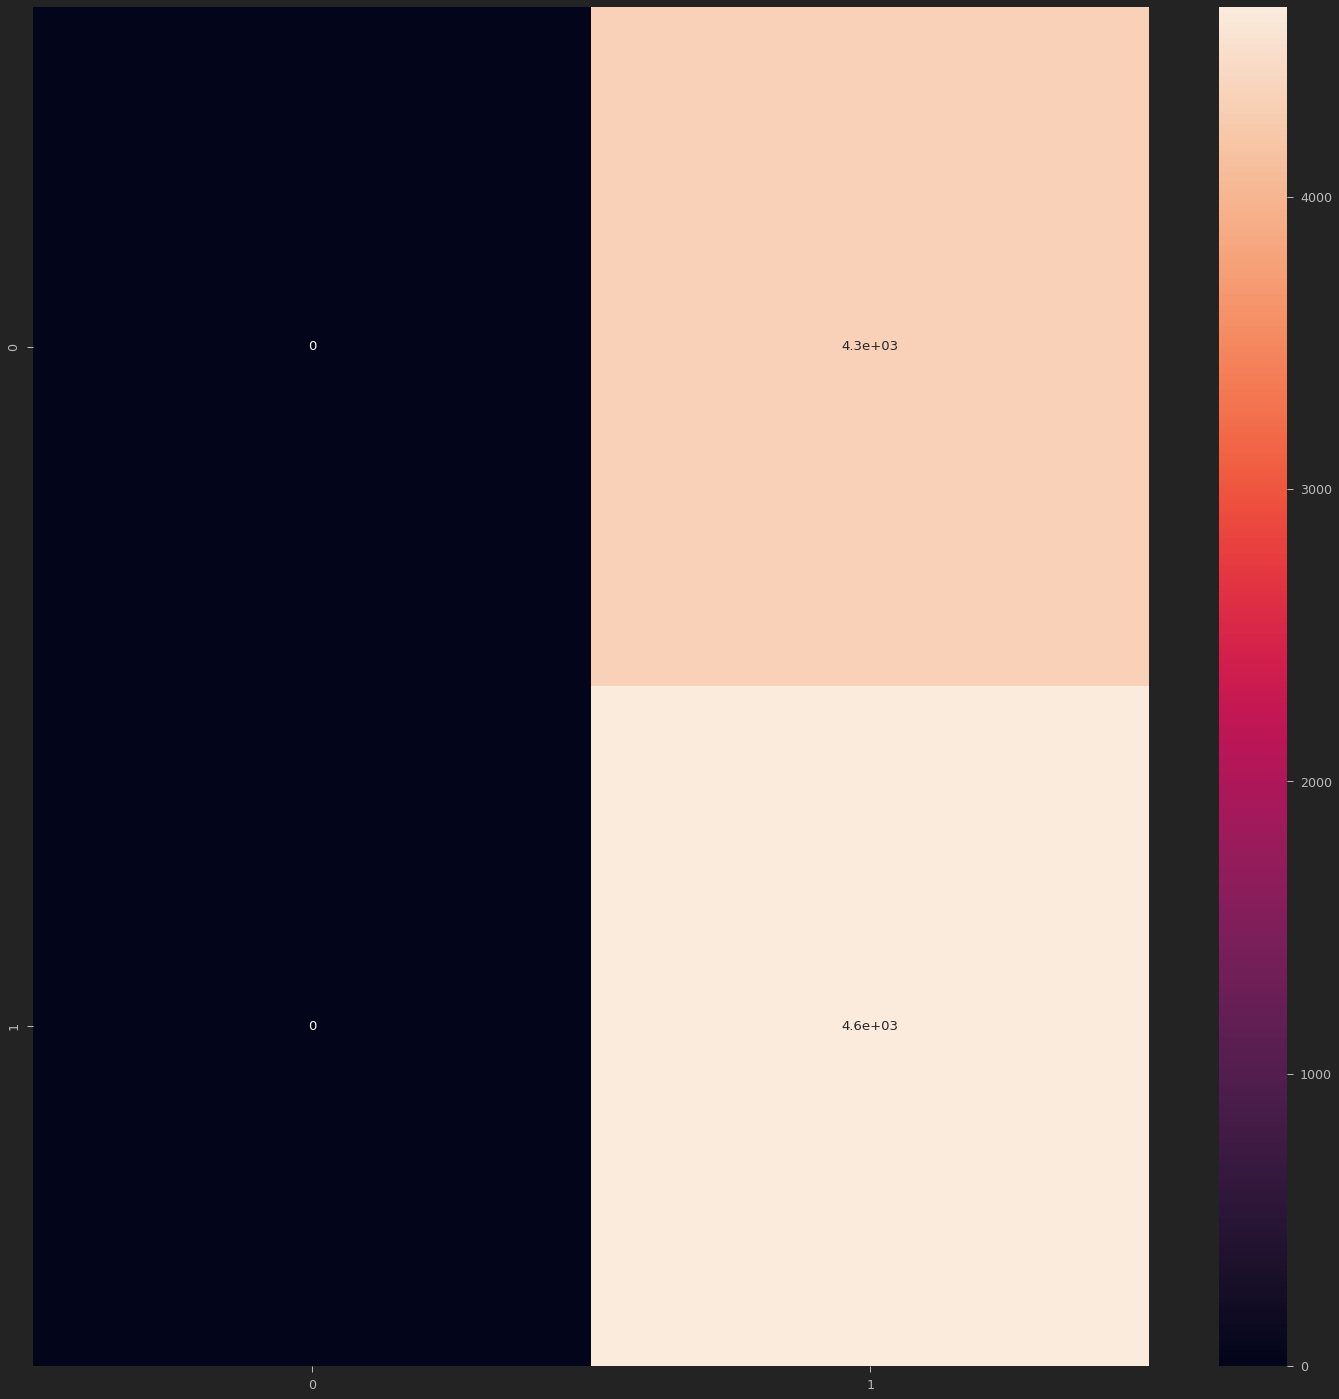

In [76]:
# getting the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(list(y_test),prediction)
plt.figure(figsize=(25,25))
sns.heatmap(cm,annot=True)

In [77]:
model.save('fakeNewsPredictor.h5')